In [31]:
%config InlineBackend.figure_format = "retina"
import arviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro import deterministic, sample, plate
from numpyro.distributions import Normal, InverseGamma, Exponential
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

from custom_plotting import ribbon_plot

numpyro.set_host_device_count(4)

In [2]:
df = pd.read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat")

In [3]:
df.columns = df.columns.str.strip()

state = "MN"
cols = ["county", "floor", "log_radon"]
df2 = df.query("state == @state").assign(log_radon=lambda x: np.log(x.activity.where(x.activity != 0, other=0.1)), county=lambda x: x.county.str.strip().str.title())[cols].reset_index(drop=True)

df2["floor"] = df2["floor"] -1
df2["floor_jittered"] = df2["floor"] + 0.01 * np.random.normal(size=len(df2))

In [4]:
df2[["county", "floor", "log_radon"]]

,county,floor,log_radon
0,Aitkin,0,0.788457
1,Aitkin,-1,0.788457
2,Aitkin,-1,1.064711
3,Aitkin,-1,0.000000
4,Anoka,-1,1.131402
...,...,...,...
914,Wright,-1,1.856298
915,Wright,-1,1.504077
916,Wright,-1,1.609438
917,Yellow Medicine,-1,1.308333


In [5]:
SAMPLE_COUNTIES = ('Lac Qui Parle', 'Aitkin', 'Stearns', 'St Louis')
RANDOM_COUNTIES = ('Lincoln',
    'Renville',
    'Kittson',
    'Yellow Medicine',
    'Olmsted',
    'Mcleod',
    'Koochiching',
    'Lake Of The Woods',
    'Roseau',
    'Benton',
    'Nobles',
)

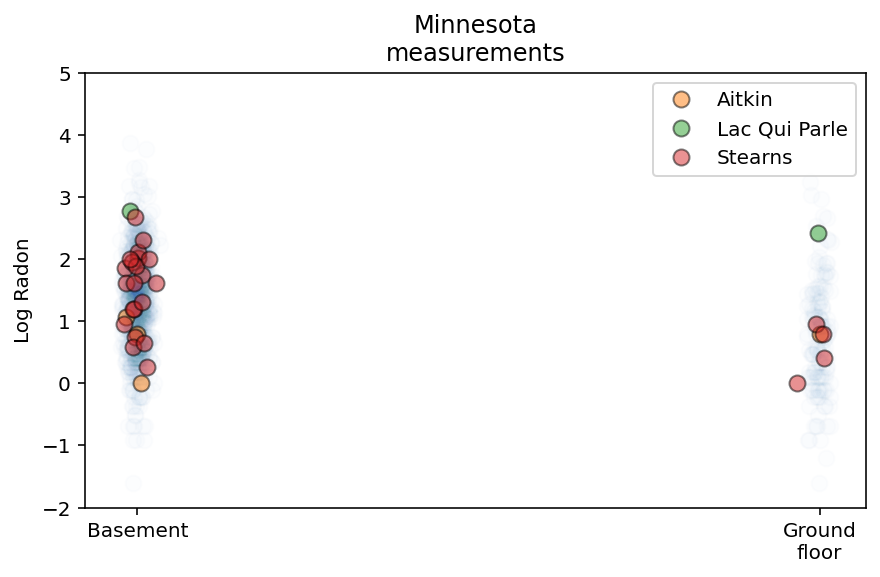

In [8]:
x = df2["floor_jittered"]
y = df2["log_radon"]


plt.figure(figsize=(7, 4))
ax = plt.gca()
ax.plot(x, y, marker='o', lw=0, ms=8, alpha=0.01)

county = "Aitkin"
data = df2.query("county == @county")[["floor_jittered", "log_radon"]]
x = data["floor_jittered"]
y = data["log_radon"]
ax.plot(x, y, marker='o', lw=0, ms=8, mec='k', mew=1, alpha=0.5, color='C1', label=county)

county = "Lac Qui Parle"
data = df2.query("county == @county")[["floor_jittered", "log_radon"]]
x = data["floor_jittered"]
y = data["log_radon"]
ax.plot(x, y, marker='o', lw=0, ms=8, mec='k', mew=1, alpha=0.5, color='C2', label=county)

county = "Stearns"
data = df2.query("county == @county")[["floor_jittered", "log_radon"]]
x = data["floor_jittered"]
y = data["log_radon"]
ax.plot(x, y, marker='o', lw=0, ms=8, mec='k', mew=1, alpha=0.5, color='C3', label=county)

ax.legend(loc='upper right')
ax.set_title("Minnesota\nmeasurements")
ax.set_xticks([-1, 0])
ax.set_xticklabels(["Basement", "Ground\nfloor"])
ax.set_ylabel("Log Radon")
ax.set_ylim([-2, 5]);

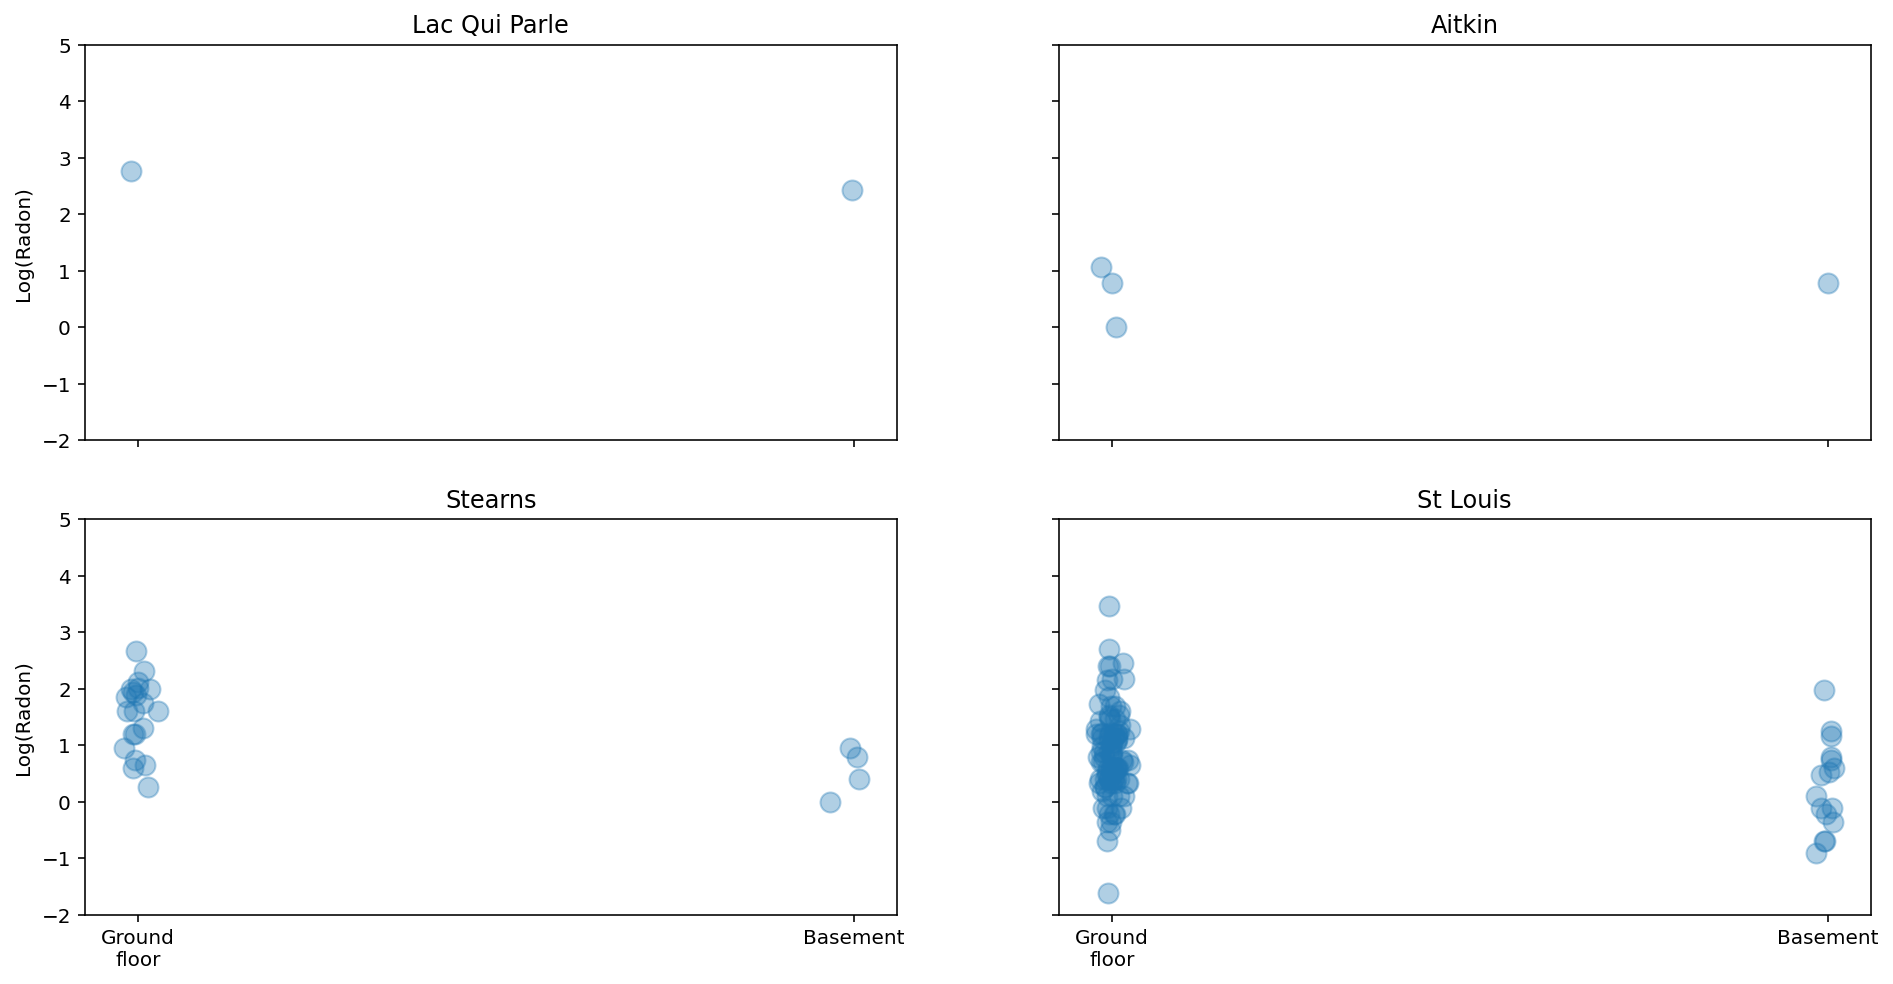

In [10]:
f, axes = plt.subplots(2, 2, figsize=(2 * 7 + 2, 2 * 4), sharex=True, sharey=True)
for c, ax in zip(SAMPLE_COUNTIES, axes.flatten()):
    data = df2.query("county == @c")[["floor_jittered", "log_radon"]]
    x = data["floor_jittered"]
    y = data["log_radon"]
    ax.plot(x, y, marker='o', lw=0, ms=10, alpha=0.35)
    ax.set_title(c)
    ax.set_xticks([-1, 0])
    ax.set_xticklabels(["Ground\nfloor", "Basement"])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Log(Radon)")
    
    ax.set_ylim([-2, 5])
plt.show()

# MCMC Settings

In [11]:
mcmc_kwargs = dict(num_samples=2000, num_warmup=2000, num_chains=4)
rng_key = random.PRNGKey(12)
seed1, seed2, seed3 = random.split(rng_key, 3)

# Complete pooling 

In [12]:
def complete_pooling(floor, log_radon=None):
    α = sample("α", Normal(0, 5))
    β = sample("β", Normal(0, 2))
    
    μ = deterministic("μ", α + β * floor)
    σ = sample("σ", InverseGamma(1, 0.5))
    sample("log_radon", Normal(μ, σ), obs=log_radon)

In [13]:
data_dict = dict(
    floor=jnp.array(df2.floor),
    log_radon=jnp.array(df2.log_radon),
)

In [14]:
pooled_mcmc = MCMC(NUTS(complete_pooling), **mcmc_kwargs)

In [15]:
pooled_mcmc.run(
    seed1,
    **data_dict
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
pooled_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      0.72      0.07      0.72      0.61      0.83   3370.69      1.00
         β     -0.61      0.07     -0.61     -0.73     -0.49   3348.59      1.00
         σ      0.82      0.02      0.82      0.79      0.85   3455.26      1.00

Number of divergences: 0


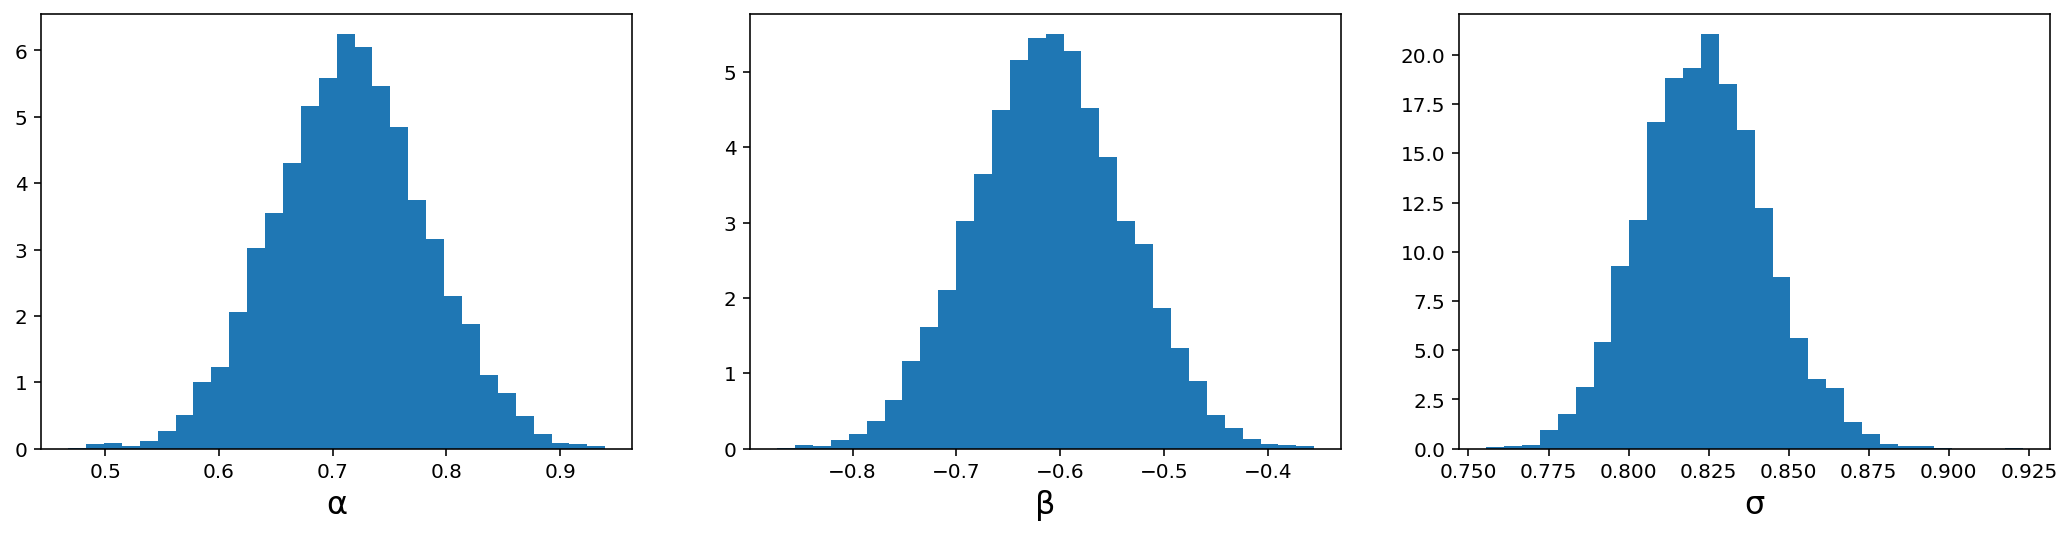

In [21]:
f, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
for param, ax in zip(["α", "β", "σ"], axes.flatten()):
    ax.hist(pooled_mcmc.get_samples()[param], bins=30, density=True)
    ax.set_xlabel(param, fontsize=16)

In [23]:
predictive = Predictive(complete_pooling, pooled_mcmc.get_samples())
x_ = np.linspace(-1.1, 0.1,)

In [ ]:
y_pred = predictive(seed1, floor=x_)["log_radon"]

plt.figure(figsize=(7, 4))
ax = plt.gca()
ribbon_plot(x_, y_pred, ribbon_color='C1', line_color='k', line_kwargs=dict(ms=0, lw=1, ls="--"), n_ribbons=10, ax=ax)

x = df2["floor_jittered"]
y = df2["log_radon"]
ax.plot(x, y, marker='o', lw=0, ms=8, alpha=0.1)
ax.set_ylim([-2, 5])
ax.set_title("Minnesota radon estimate\nincluding noise")
ax.set_xticks([-1, 0])
ax.set_xticklabels(["Basement", "Ground\nfloor"])
ax.set_ylabel("Log Radon")
plt.show()

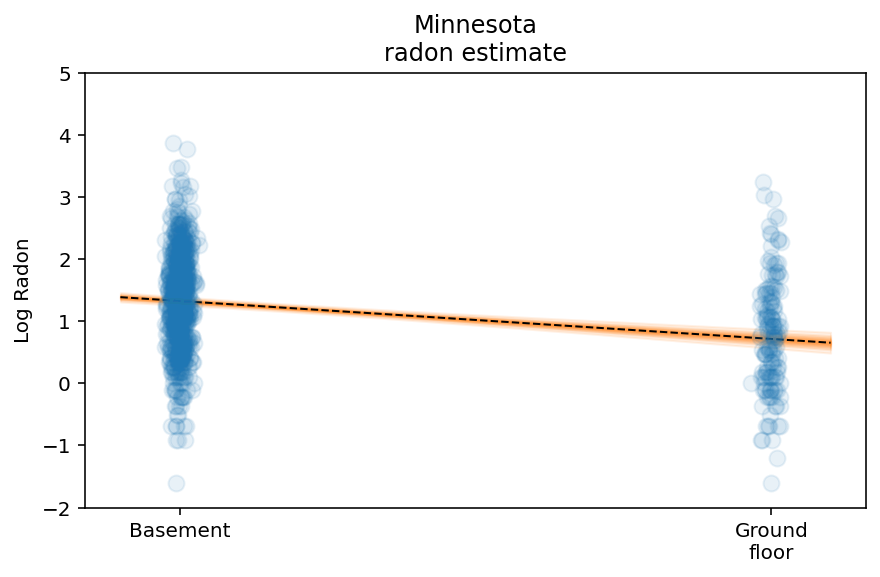

In [29]:
mu_pred = predictive(seed1, floor=x_)["μ"]

plt.figure(figsize=(7, 4))
ax = plt.gca()
ribbon_plot(x_, mu_pred, ribbon_color='C1', line_color='k', line_kwargs=dict(ms=0, lw=1, ls="--"), n_ribbons=10, ax=ax)

x = df2["floor_jittered"]
y = df2["log_radon"]
ax.plot(x, y, marker='o', lw=0, ms=8, alpha=0.1)
ax.set_ylim([-2, 5])
ax.set_title("Minnesota\nradon estimate")
ax.set_xticks([-1, 0])
ax.set_xticklabels(["Basement", "Ground\nfloor"])
ax.set_ylabel("Log Radon")
plt.show()

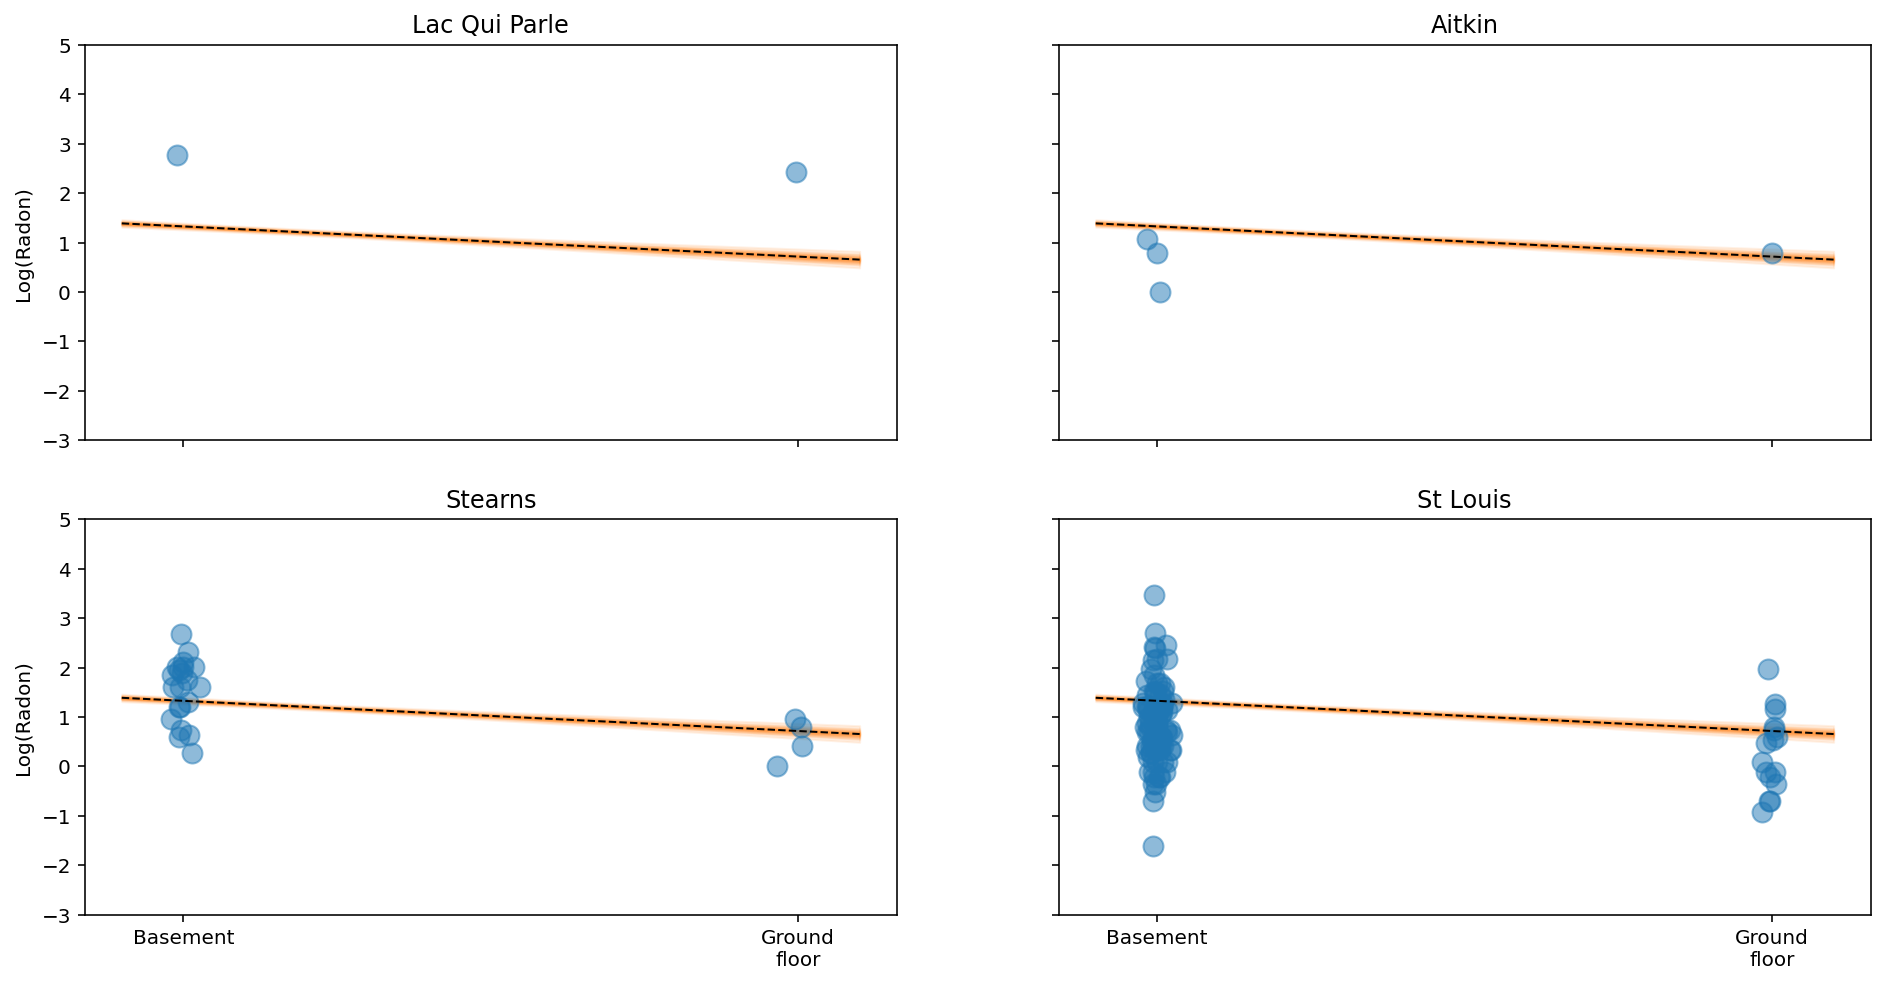

In [30]:
f, axes = plt.subplots(2, 2, figsize=(2 * 7 + 2, 2 * 4), sharex=True, sharey=True)
for c, ax in zip(SAMPLE_COUNTIES, axes.flatten()):
    data = df2.query("county == @c")[["floor_jittered", "log_radon"]]
    x = data["floor_jittered"]
    y = data["log_radon"]
    ax.plot(x, y, marker='o', lw=0, ms=10, alpha=0.5)
    ax.set_title(c)
    ax.set_xticks([-1, 0])
    ax.set_xticklabels(["Basement", "Ground\nfloor"])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Log(Radon)")
    
    ribbon_plot(x_, mu_pred, ribbon_color="C1", ax=ax, line_color='k', line_kwargs=dict(ms=0, lw=1, ls="--"))
    
    ax.set_ylim([-3, 5])
    
plt.show()

# No pooling

In [33]:
encoder = LabelEncoder()
encoder.fit(df2["county"])
N_COUNTIES = len(encoder.classes_)

In [34]:
def no_pooling(county, floor, log_radon=None):
    # N_COUNTIES was defined in global scope
    with plate("counties", N_COUNTIES):
        α = sample("α", Normal(0, 5))
        β = sample("β", Normal(0, 1))

    μ = deterministic("μ", α[county] + β[county] * floor)
    τ = sample("τ", InverseGamma(1, 0.5))
    sample("log_radon", Normal(μ, τ), obs=log_radon)

In [35]:
mcmc = MCMC(NUTS(no_pooling), **mcmc_kwargs)

In [36]:
county = jnp.array(encoder.transform(df2.county))
data_dict.update({"county": county})

In [37]:
mcmc.run(seed2, **data_dict)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [39]:
c_names = sorted(SAMPLE_COUNTIES + RANDOM_COUNTIES, reverse=True)
c_nums = encoder.transform(c_names)

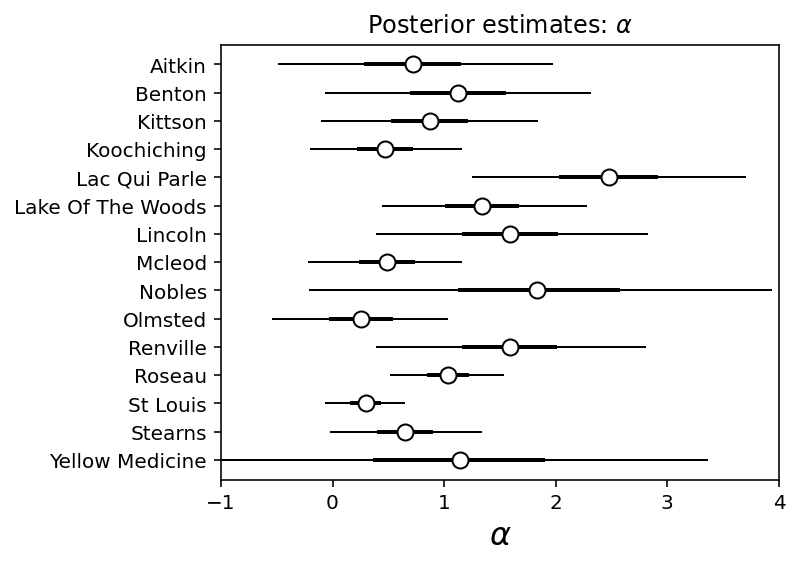

In [40]:
yticks = []
labels = []
plt.figure(figsize=(5, 4))
for y, (name, num) in enumerate(zip(c_names, c_nums)):
    alpha = mcmc.get_samples()["α"][:, num]
    low, mid_low, mid, mid_high, high = np.quantile(alpha, [0.025, 0.25, 0.50, 0.75, 0.975])
    plt.plot([low, high], [y, y], lw=1, color='k', ms=0)
    plt.plot([mid_low, mid_high], [y, y], lw=2, color='k', ms=0)
    plt.plot(mid, y, marker='o', ms=8, lw=0, color='w', mec='k', mew=1)
    yticks.append(y)
    labels.append(name)
plt.yticks(yticks, labels)
plt.xlabel("$\\alpha$", fontsize=16)
plt.xlim([-1, 4])
plt.title("Posterior estimates: $\\alpha$")
plt.show()

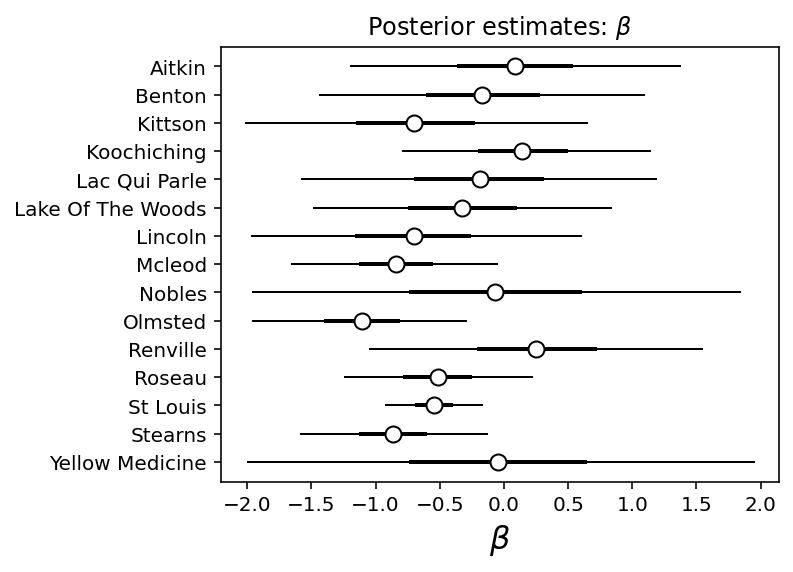

In [41]:
yticks = []
labels = []
plt.figure(figsize=(5, 4))
for y, (name, num) in enumerate(zip(c_names, c_nums)):
    beta = mcmc.get_samples()["β"][:, num]
    low, mid_low, mid, mid_high, high = np.quantile(beta, [0.025, 0.25, 0.50, 0.75, 0.975])
    plt.plot([low, high], [y, y], lw=1, color='k', ms=0)
    plt.plot([mid_low, mid_high], [y, y], lw=2, color='k', ms=0)
    plt.plot(mid, y, marker='o', ms=8, lw=0, color='w', mec='k', mew=1)
    yticks.append(y)
    labels.append(name)
plt.yticks(yticks, labels)
plt.xlabel("$\\beta$", fontsize=16)
plt.title("Posterior estimates: $\\beta$")
plt.show()

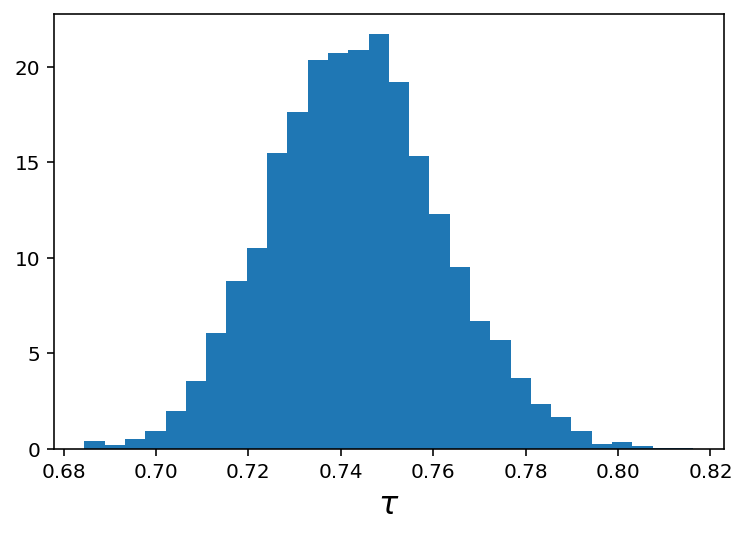

In [42]:
plt.hist(mcmc.get_samples()["τ"], bins=30, density=True)
plt.xlabel("$\\tau$", fontsize=16);

In [43]:
predictive = Predictive(no_pooling, mcmc.get_samples())

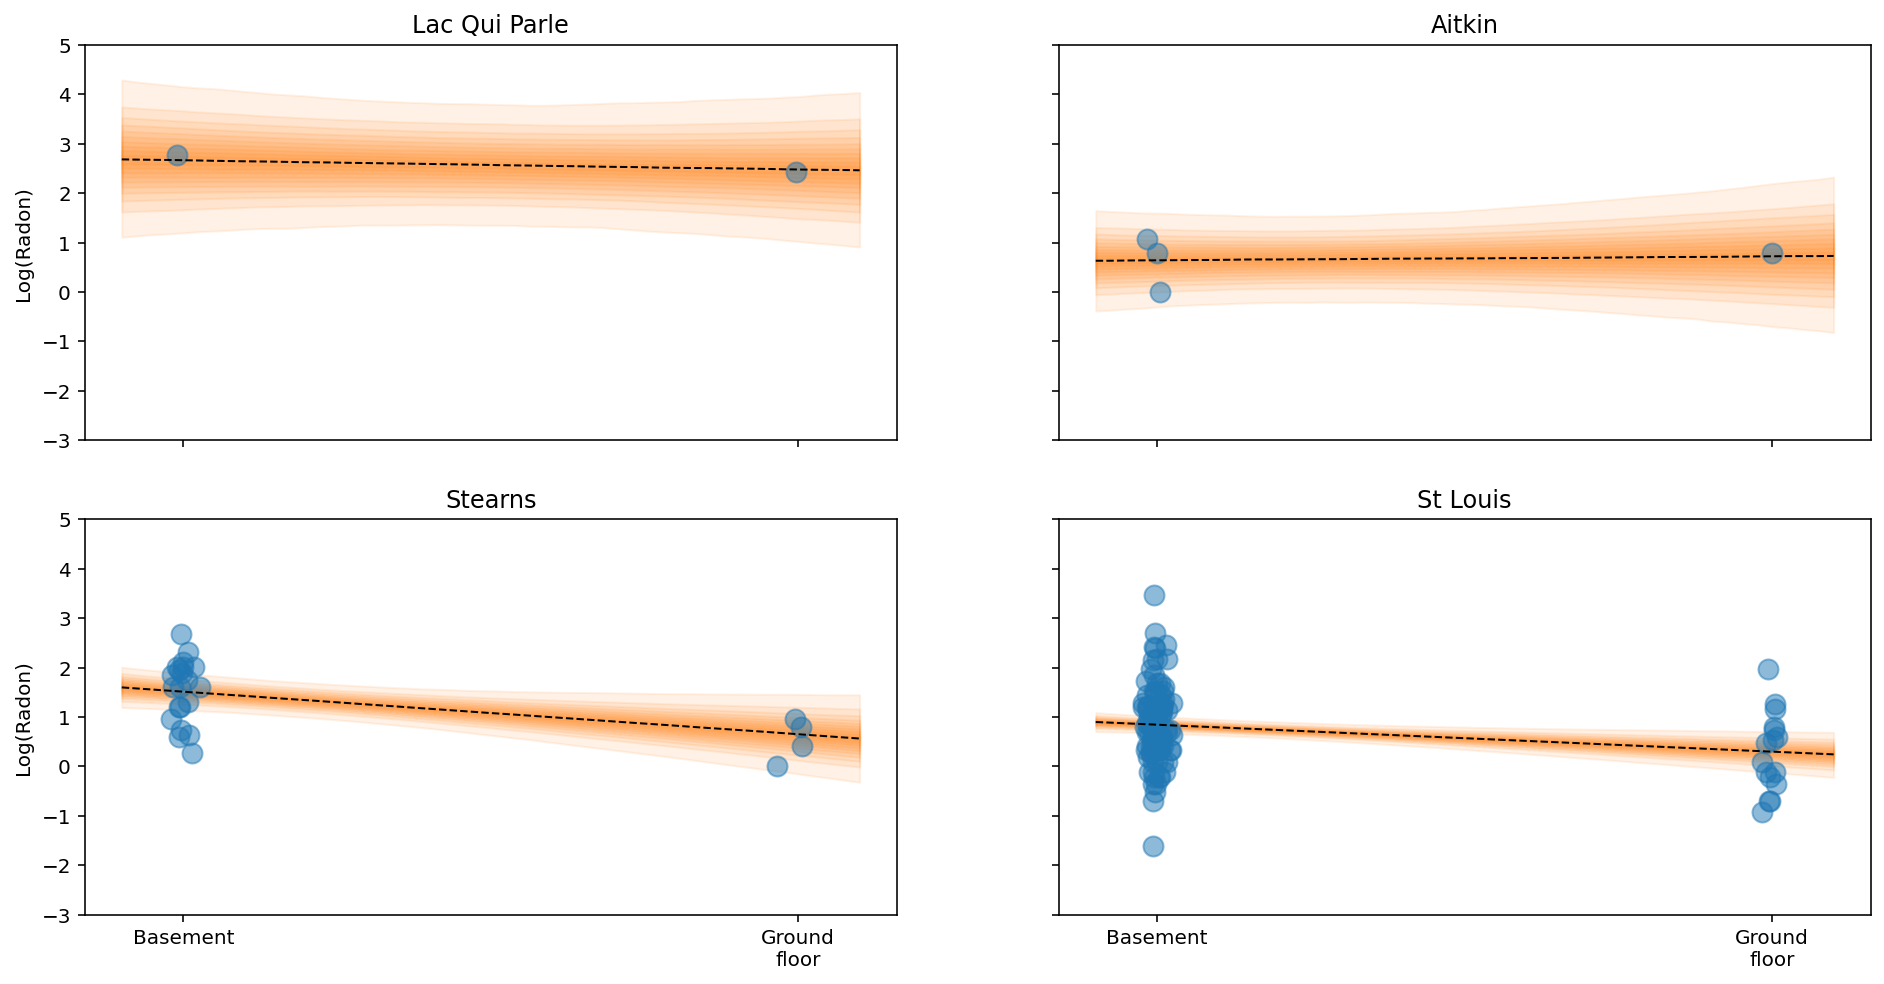

In [46]:
f, axes = plt.subplots(2, 2, figsize=(2 * 7 + 2, 2 * 4), sharex=True, sharey=True)
for c, ax in zip(SAMPLE_COUNTIES, axes.flatten()):
    data = df2.query("county == @c")[["floor_jittered", "log_radon"]]
    x = data["floor_jittered"]
    y = data["log_radon"]
    ax.plot(x, y, marker='o', lw=0, ms=10, alpha=0.5)
    ax.set_title(c)
    ax.set_xticks([-1, 0])
    ax.set_xticklabels(["Basement", "Ground\nfloor"])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Log(Radon)")
    
    
    nc = encoder.transform([c])[0]
    mu_pred = predictive(
        random.PRNGKey(123),
        county=jnp.array([nc,] * len(x_)),
        floor=jnp.array(x_),

    )["μ"]
    ribbon_plot(x_, mu_pred, ribbon_color="C1", ax=ax, line_color='k', line_kwargs=dict(ms=0, lw=1, ls="--"))
    ax.set_ylim([-3, 5])
plt.show()

# Partial pooling

In [48]:
def partial_pooling(σ_α, county, floor, log_radon=None):

    μ_α = sample("μ_α", Normal(0, 5))
    
    with plate("counties", N_COUNTIES):
        α = sample("α", Normal(μ_α, σ_α))
        β = sample("β", Normal(0, 1))
    
    μ = deterministic("μ", α[county] + β[county] * floor)
    τ = sample("τ", InverseGamma(1, 0.5))
    sample("log_radon", Normal(μ, τ), obs=log_radon)

In [49]:
mcmc = MCMC(NUTS(partial_pooling), progress_bar=False, **mcmc_kwargs)

In [50]:
pooled_alphas = {}
pooled_taus = {}
for σ_α in [0.01, 0.02, 0.05, 0.07, 0.09] + list(np.linspace(0.1, 1, num=20)):
    print("Pooling: ", σ_α)
    data_dict.update({"σ_α": σ_α})
    mcmc.run(seed3, **data_dict)
    pooled_alphas[σ_α] = mcmc.get_samples()["α"]
    pooled_taus[σ_α] = mcmc.get_samples()["τ"]

Pooling:  0.01
Pooling:  0.02
Pooling:  0.05
Pooling:  0.07
Pooling:  0.09
Pooling:  0.1
Pooling:  0.1473684210526316
Pooling:  0.19473684210526315
Pooling:  0.24210526315789474
Pooling:  0.2894736842105263
Pooling:  0.33684210526315794
Pooling:  0.38421052631578945
Pooling:  0.43157894736842106
Pooling:  0.4789473684210527
Pooling:  0.5263157894736842
Pooling:  0.5736842105263158
Pooling:  0.6210526315789474
Pooling:  0.6684210526315789
Pooling:  0.7157894736842105
Pooling:  0.7631578947368421
Pooling:  0.8105263157894737
Pooling:  0.8578947368421053
Pooling:  0.9052631578947369
Pooling:  0.9526315789473684
Pooling:  1.0


In [60]:
keys = list(pooled_alphas.keys())
len(keys)

25

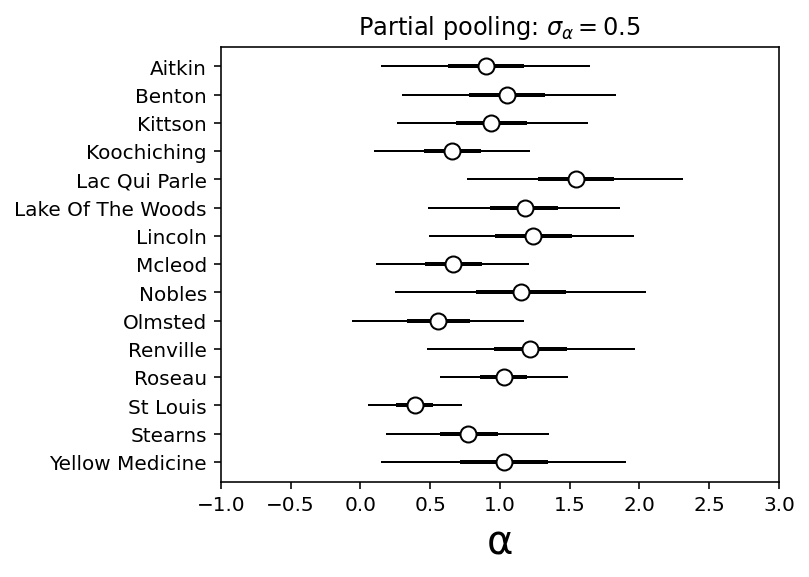

In [61]:
yticks = []
labels = []
k = 13
plt.figure(figsize=(5, 4))
for y, (name, num) in enumerate(zip(c_names, c_nums)):
    samples = pooled_alphas[keys[k]][:, num]
    low, mid_low, mid, mid_high, high = np.quantile(samples, [0.025, 0.25, 0.50, 0.75, 0.975])
    plt.plot([low, high], [y, y], lw=1, color='k', ms=0)
    plt.plot([mid_low, mid_high], [y, y], lw=2, color='k', ms=0)
    plt.plot(mid, y, marker='o', ms=8, lw=0, color='w', mec='k', mew=1)
    yticks.append(y)
    labels.append(name)
plt.yticks(yticks, labels)
plt.xlabel("α", fontsize=20)
plt.xlim([-1, 3])
plt.title(f"Partial pooling: $\\sigma_\\alpha = {keys[k]:0.1f}$")
plt.show()

In [75]:
mean_alphas = []
for k, samples in pooled_alphas.items():
    alphas = samples.mean(axis=0)
    mean_alphas.append(alphas[c_nums])
mean_alphas = np.array(mean_alphas)

In [76]:
order = np.argsort(mean_alphas[-1])

In [77]:
text_ys = mean_alphas[-1][order] + [-0.03, +0.03, -0.03, 0.03, 0, 0, 0, -0.03, 0, 0.03, 0, -0.05, 0, 0.05, 0]

In [78]:
sorted_names = [c_names[i] for i in order]

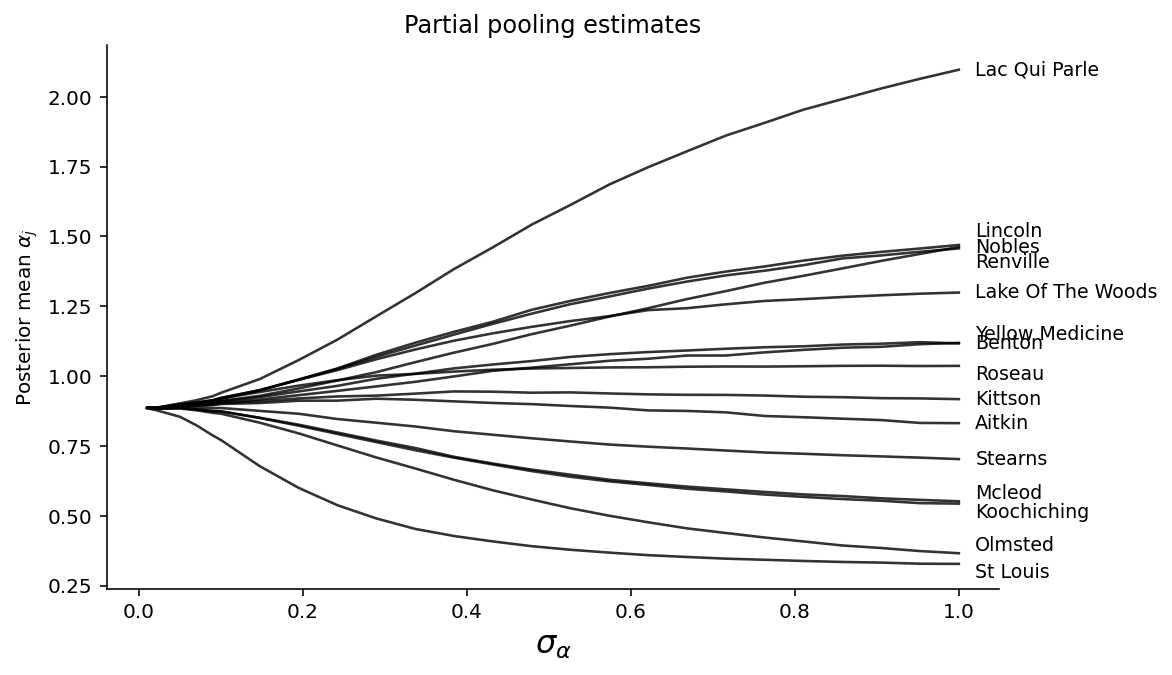

In [86]:
plt.figure(figsize=(8, 5))
for name, y in zip(c_names, mean_alphas.T):
    plt.plot(keys, y, ms=0, color='k', alpha=0.8, lw=1.3)

for name, y in zip(sorted_names, text_ys):
    plt.annotate(name, (keys[-1]+0.02, y), verticalalignment='center', fontsize=9.5)

plt.xlabel("$\\sigma_\\alpha$", fontsize=16)
plt.ylabel("Posterior mean $\\alpha_j$")
plt.title("Partial pooling estimates")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.show()

# Hierarchical model